In [1]:
import pandas as pd
import numpy as np

# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(file_url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# select relevant data
relevant_proximities = ['<1H OCEAN','INLAND']
df = df[df['ocean_proximity'].isin(relevant_proximities)]

#### Preparation

In [3]:
# Fill missing values with zeros.
df.fillna(0, inplace=True)

# Apply the log tranform to median_house_value.
df['median_house_value'] = np.log1p(df.median_house_value)

# Do train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split
## shuffle the dataset using seed 42
#n = len(df)
#idx = np.arange(n)
#np.random.seed(42)
#np.random.shuffle(idx)
#df_shuffled = df.iloc[idx]

# Use the train_test_split function and set the random_state parameter to 1.
# split the data into train/val/test with 60%/20%/20%
# df_full, df_test = train_test_split(df_shuffled, test_size=np.round(len(df)*.2).astype(int), random_state=1)
df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=1)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=1)

df_full = df_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [4]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
from sklearn.feature_extraction import DictVectorizer

In [5]:
features = df_train.columns.to_list()
df_train_dict=df_train[features].to_dict(orient='records')
df_val_dict=df_val[features].to_dict(orient='records')
df_test_dict=df_test[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(df_train_dict)

DictVectorizer(sparse=False)

In [6]:
X_train = dv.transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1.`

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [8]:
# TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [9]:
# when using shuffled data
## TRAINING THE REGRESSION MODEL:
#dt = DecisionTreeRegressor(max_depth=1)
#dt.fit(X_train, y_train)
#
## INSPECTION:
#print(export_text(dt, feature_names=dv.feature_names_))

### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1 (optional-to make training faster)`

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [11]:
# TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
# CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2429554248133476

In [13]:
# when using shuffled data
## CALCULATING MEAN SQUARED ERROR:
#y_pred = rf.predict(X_val)
#np.sqrt(mean_squared_error(y_val, y_pred))

### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [14]:
from tqdm.auto import tqdm

/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [01:15<00:00,  3.80s/it]


In [16]:
best_rmse = float("inf")
best_n_estimators = 0
counter = 0

# for index, rmse in enumerate(scores):
for n_rmse in scores:
    # Checking if RMSE stops improving
    if n_rmse[1] < best_rmse:
        best_rmse = n_rmse[1]
        best_n_estimators = n_rmse[0]
    else:
        counter += 1
        if counter == 5:  # If the RMSE hasn't improved for 5 iterations, break the loop
            break

print(f"After {best_n_estimators} estimators, RMSE stops improving.")

After 200 estimators, RMSE stops improving.


In [17]:
import matplotlib.pyplot as plt

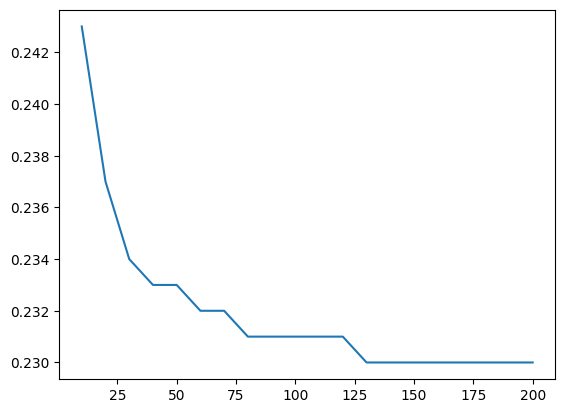

In [18]:
# INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [19]:
## when using shuffled data
#best_rmse = float("inf")
#best_n_estimators = 0
#counter = 0
#
## for index, rmse in enumerate(scores):
#for n_rmse in scores:
#    # Checking if RMSE stops improving
#    if n_rmse[1] < best_rmse:
#        best_rmse = n_rmse[1]
#        best_n_estimators = n_rmse[0]
#    else:
#        counter += 1
#        if counter == 5:  # If the RMSE hasn't improved for 5 iterations, break the loop
#            break
#
#print(f"After {best_n_estimators} estimators, RMSE stops improving.")

In [20]:
## INSPECTING THE RMSE SCORES:
#plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
#plt.show()

### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [21]:
# TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


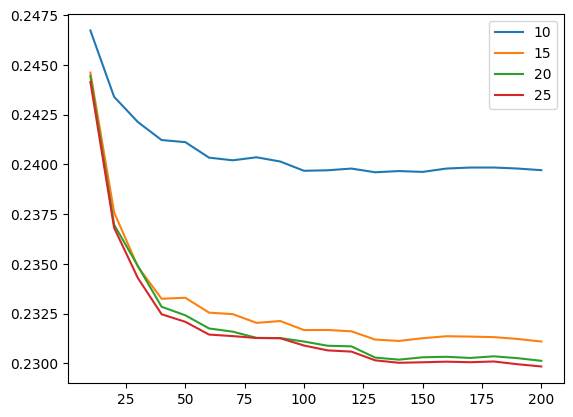

In [22]:
# PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [ ]:
## when using shuffled data
## PLOTTING THE GRAPH:
#for d in [10, 15, 20, 25]:
#    df_subset = df_scores[df_scores.max_depth == d]
#    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)
#
#plt.legend()
#plt.show()

### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,  
  * `max_depth=20`,  
  * `random_state=1`,  
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


In [23]:
# TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


# GET FEATURE IMPORTANCE INFORMATION
rf.feature_importances_

array([0.0157157 , 0.03298617, 0.10274898, 0.0817063 , 0.33557258,
       0.18152397, 0.18252986, 0.0266511 , 0.01735778, 0.02320755])

In [40]:
sorted([z for z in zip(dv.feature_names_, rf.feature_importances_)], key=lambda x: x[1], reverse=True)[:3]

[('median_income', 0.33557258143991675),
 ('ocean_proximity=INLAND', 0.18252985653883133),
 ('ocean_proximity=<1H OCEAN', 0.18152397342639143)]

In [41]:
## when using shuffled data
#sorted([z for z in zip(dv.feature_names_, rf.feature_importances_)], key=lambda x: x[1], reverse=True)[:3]

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from 0.3 to 0.1.

In [42]:
import xgboost as xgb
import re

In [59]:
# CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [104]:
# INITIALIZATION:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}
iters = list(np.arange(0,100))

# TRAIN AND SAVE RESULTS
for eta in [0.3, 0.1]:
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
        }
        
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist, evals_result=evals_result)
    scores[eta] = evals_result['val']['rmse']

[0]	train-rmse:0.44211	val-rmse:0.44440
[5]	train-rmse:0.25075	val-rmse:0.26960


[10]	train-rmse:0.21399	val-rmse:0.24443
[15]	train-rmse:0.19784	val-rmse:0.23728
[20]	train-rmse:0.18584	val-rmse:0.23262
[25]	train-rmse:0.17781	val-rmse:0.23052
[30]	train-rmse:0.17111	val-rmse:0.22869
[35]	train-rmse:0.16496	val-rmse:0.22844
[40]	train-rmse:0.15783	val-rmse:0.22726
[45]	train-rmse:0.15315	val-rmse:0.22612
[50]	train-rmse:0.14718	val-rmse:0.22458
[55]	train-rmse:0.14124	val-rmse:0.22299
[60]	train-rmse:0.13718	val-rmse:0.22219
[65]	train-rmse:0.13435	val-rmse:0.22212
[70]	train-rmse:0.12976	val-rmse:0.22170
[75]	train-rmse:0.12677	val-rmse:0.22131
[80]	train-rmse:0.12392	val-rmse:0.22103
[85]	train-rmse:0.12031	val-rmse:0.22119
[90]	train-rmse:0.11614	val-rmse:0.22097
[95]	train-rmse:0.11299	val-rmse:0.22089
[99]	train-rmse:0.11074	val-rmse:0.22120
[0]	train-rmse:0.44211	val-rmse:0.44440
[5]	train-rmse:0.25075	val-rmse:0.26960
[10]	train-rmse:0.21399	val-rmse:0.24443
[15]	train-rmse:0.19784	val-rmse:0.23728
[20]	train-rmse:0.18584	val-rmse:0.23262
[25]	train-rmse:0.

In [107]:
plt.plot()

[0.4443987578383685,
 0.36878256969463163,
 0.32273596046702996,
 0.2949876000803516,
 0.2770686574852469,
 0.26960221802428863,
 0.2599897372350027,
 0.25438780259897187,
 0.24927079608467492,
 0.24765281517651366,
 0.244431895281874,
 0.24241422077085634,
 0.24023590026153052,
 0.2388002934003315,
 0.2379709300704143,
 0.23727964196540596,
 0.23665608430080945,
 0.23518226968770517,
 0.2339529450976349,
 0.23324672906987043,
 0.23261950014270474,
 0.23104471238067165,
 0.23137120626569155,
 0.23125856379938176,
 0.23096612595374244,
 0.23052482857332549,
 0.2301795213381888,
 0.2293488144124325,
 0.22909164912999005,
 0.22885501559518356,
 0.22868788809260798,
 0.22835924021822326,
 0.22819320808541083,
 0.2287335999663407,
 0.22850520457589907,
 0.2284399104133846,
 0.22790658987853787,
 0.22781481418168678,
 0.22786610136790605,
 0.22748241300189032,
 0.2272579691103854,
 0.22710412035289407,
 0.2268979567514915,
 0.22639324738398833,
 0.22619335154125966,
 0.2261179916665803,
 0.2

In [94]:
for key, value in evals_result.items():
    print(f"{key} scores:")
    for metric, score in value.items():
        print(f"{metric}: {score}")
    print('\n')

train scores:
rmse: [0.44210750607641913, 0.36306133936105245, 0.3148471666300576, 0.2831653321847578, 0.2621820467268595, 0.25074883675522475, 0.23881312600328358, 0.2294195964157866, 0.22359806806355065, 0.21899595675534694, 0.21398959804239706, 0.20937125753398717, 0.2052945659794787, 0.2016124048589576, 0.19909100718382672, 0.19784112425745276, 0.1955919851905064, 0.19314818578115894, 0.19015448259065776, 0.18860999045249532, 0.18583831708721843, 0.18334264508161202, 0.18129613280305826, 0.17991589495745478, 0.17910664351033398, 0.17780554758976638, 0.17687674390749758, 0.17483100432405946, 0.1735271418526011, 0.17233208402436934, 0.17111494327122753, 0.16898081491657552, 0.16807790354199467, 0.16666053215156607, 0.16557502301880245, 0.16495975476361047, 0.16314010197190987, 0.1621498461088874, 0.16079214432822106, 0.1591145448277679, 0.15783256805870932, 0.15675764058251285, 0.15582408113589102, 0.15485944521954093, 0.15397017148497116, 0.1531519774364613, 0.15261564125212193, 0.1

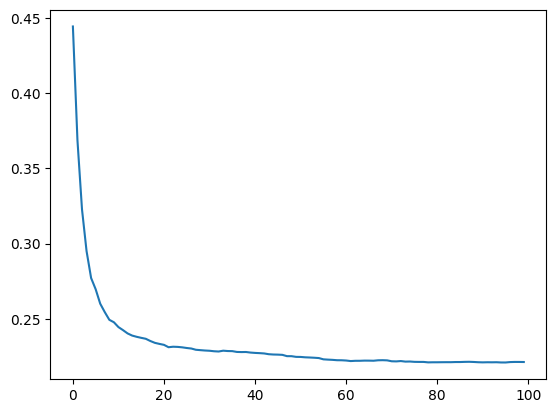

In [103]:
evals_result['val']['rmse']
# plt.plot(np.arange(0,len(evals_result['val']['rmse']), evals_result['val']['rmse']))
plt.plot(
    list(np.arange(0, len(evals_result['val']['rmse']))),
)

In [69]:
# for line in output.stdout.strip().split('\n'):
#     it_line, train_line, val_line = line.split('\t')
# 
#     it = int(it_line.strip('[]'))
#     train = float(train_line.split(':')[1])
#     val = float(val_line.split(':')[1])
#     
#     results.append((it, train, val))
output.stdout.strip().split('\n')[0].split('\t')

['[0]', 'train-rmse:0.44211', 'val-rmse:0.44440']

In [75]:
model.eval_set

<bound method Booster.eval_set of <xgboost.core.Booster object at 0x7fcf7e7acaf0>>